# ODR test
Attempt to do nonlinear Orthogonal Distance Regression (more properly, [Total Least Squares regression](https://en.wikipedia.org/wiki/Total_least_squares)) using MCMC.

I'm hoping that this is as simple as finding an appropriate likelihood function and then just running the sampler.

## References
- `scipy.odr` [docs](https://docs.scipy.org/doc/scipy/reference/odr.html), including the underlying [`ODRPACK` library's user guide](https://docs.scipy.org/doc/external/odrpack_guide.pdf)

In [1]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt

In [4]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

## Simulate data
For the first test I'll use a simple linear model with normal errors in both `x` and `y`.

In [53]:
# ground truth
m = 3.0 # slope
b = 1.0 # y intercept

def f_true(x, m, b):
    return m*x+b

In [5]:
# initialize numpy random number generator
SEED=20230728 # seed for rng
rng = np.random.default_rng(SEED)

In [7]:
# errors
sigma_x = 0.1
sigma_y = 0.1

n_points = 10

x_true = np.random.uniform(low=0,high=1,size=n_points)
y_true = f_true(x_true,m,b)

In [9]:
# add errors
x_data = x_true + np.random.normal(loc=0,scale=sigma_x,size=n_points)
y_data = y_true + np.random.normal(loc=0,scale=sigma_y,size=n_points)

(0.0, 4.0)

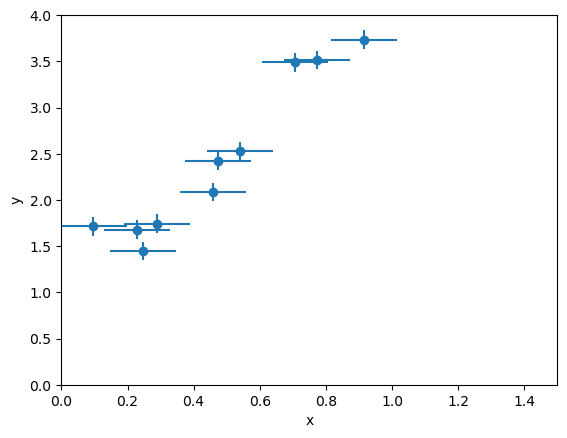

In [20]:
# plot the data
plt.errorbar(x=x_data,y=y_data,xerr=sigma_x,yerr=sigma_y,fmt='o')
plt.xlabel('x')
plt.ylabel("y")
plt.xlim(0,1.5)
plt.ylim(0,4)

In [15]:
data_array = np.array([x_data, y_data]).T

In [16]:
data_array

array([[0.45883398, 2.08412629],
       [0.77248571, 3.5158386 ],
       [0.2287618 , 1.67981882],
       [0.29031054, 1.74423043],
       [0.24624183, 1.44654434],
       [0.53883316, 2.52644365],
       [0.09691728, 1.71330912],
       [0.47376297, 2.42145927],
       [0.70642564, 3.48901724],
       [0.91570229, 3.73615312]])

In [17]:
std_array = np.array([sigma_x,sigma_y])

In [18]:
std_array

array([0.1, 0.1])

In [23]:
def f_implicit(x,y,m,b):
    '''
    Implicit fitting function.  This should nominally equal zero.
    '''
    return y-f_true(x,m,b)

In [24]:
f_implicit(x_data,y_data,m,b)

array([-2.92375652e-01,  1.98381468e-01, -6.46656934e-03, -1.26701196e-01,
       -2.92181136e-01, -9.00558220e-02,  4.22557268e-01,  1.70374267e-04,
        3.69740336e-01, -1.09537442e-02])

In [54]:
with pm.Model() as model:
    x = pm.MutableData('x', x_data, dims="samples")
    y = pm.MutableData('y', y_data, dims="samples")

    # priors for the fitting parameters
    # Uniform distribution is equivalent to max likelihood estimate
    # Use other distributions for Bayesian priors
    m_fit = pm.Uniform('m_fit',lower=0.0,upper=10.0,shape=(1,))
    b_fit = pm.Uniform('b_fit',lower=0,upper=10,shape=(1,))

    # latent variables
    # assume sigmas are known and correct
    x_latent = pm.Normal('x_latent', mu=x, sigma=sigma_x, dims="samples")
    y_latent = pm.Normal('y_latent', mu=y, sigma=sigma_y, dims='samples')

    # log likelihood function (minus the `score` for normal errors)
    logp = -(f_implicit(x_latent,y_latent,m_fit,b_fit)**2)

    pot = pm.Potential('pot', logp)

In [55]:
with model:
    idata = pm.sample_prior_predictive(500)

/tmp/ipykernel_115141/2174265191.py:2: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive(500)
Sampling: [b_fit, m_fit, x_latent, y_latent]


In [56]:
model

   m_fit ~ Uniform(0, 10)
   b_fit ~ Uniform(0, 10)
x_latent ~ Normal(<shared>, 0.1)
y_latent ~ Normal(<shared>, 0.1)
     pot ~ Potential(f(y_latent, b_fit, x_latent, m_fit))

In [57]:
with model:
    idata.extend(pm.sample())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_fit, b_fit, x_latent, y_latent]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [58]:
az.summary(idata,var_names=['m_fit','b_fit'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m_fit[0],2.829,0.872,1.284,4.508,0.016,0.012,2796.0,2190.0,1.0
b_fit[0],1.101,0.469,0.191,1.945,0.009,0.006,2811.0,1771.0,1.0


array([[<Axes: title={'center': 'm_fit'}>,
        <Axes: title={'center': 'm_fit'}>],
       [<Axes: title={'center': 'b_fit'}>,
        <Axes: title={'center': 'b_fit'}>]], dtype=object)

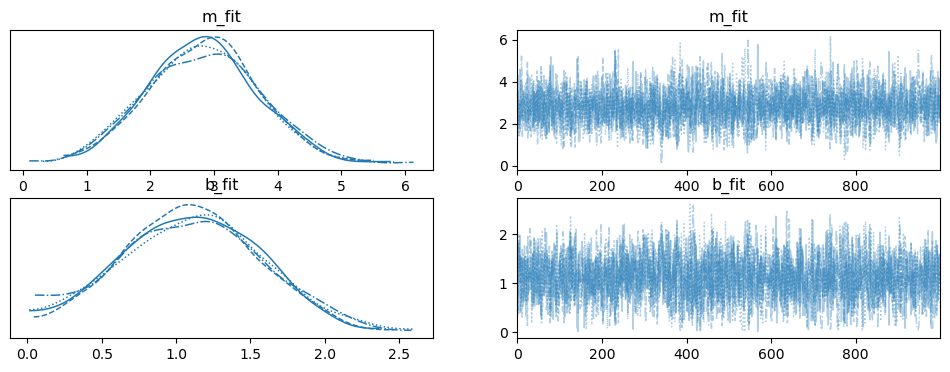

In [59]:
az.plot_trace(idata,var_names=['m_fit','b_fit'])

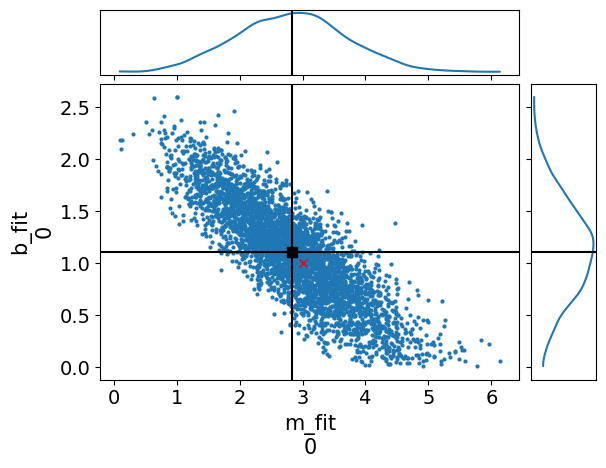

In [72]:
axes=az.plot_pair(idata,var_names=['m_fit','b_fit'],marginals=True,point_estimate='median')
axes[1,0].plot(m,b,'rx') # HACK manually plot ground truth

In [73]:
az.summary(idata,var_names=['x_latent'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x_latent[0],0.446,0.096,0.273,0.631,0.001,0.001,5976.0,3085.0,1.0
x_latent[1],0.781,0.094,0.611,0.961,0.001,0.001,6457.0,2959.0,1.0
x_latent[2],0.229,0.092,0.057,0.403,0.001,0.001,5638.0,2861.0,1.0
x_latent[3],0.282,0.090,0.110,0.446,0.001,0.001,5713.0,2773.0,1.0
x_latent[4],0.233,0.093,0.062,0.406,0.001,0.001,5490.0,2790.0,1.0
x_latent[5],0.531,0.094,0.356,0.702,0.001,0.001,5530.0,2965.0,1.0
x_latent[6],0.117,0.092,-0.052,0.293,0.001,0.001,5491.0,3050.0,1.0
x_latent[7],0.472,0.094,0.289,0.641,0.001,0.001,6443.0,2945.0,1.0
x_latent[8],0.721,0.090,0.560,0.894,0.001,0.001,5909.0,2854.0,1.0
x_latent[9],0.914,0.097,0.728,1.091,0.001,0.001,5198.0,3008.0,1.0


Text(0.5, 1.0, 'Sampler residuals for x')

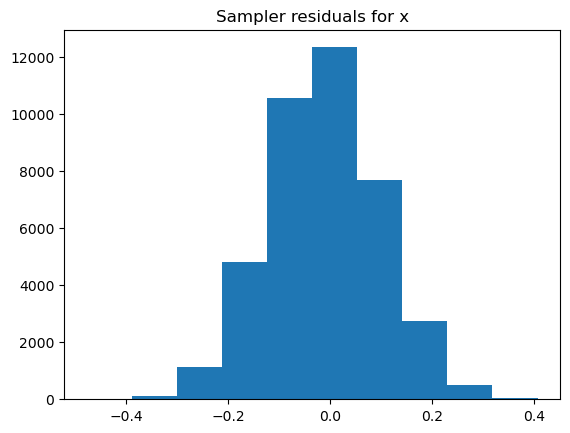

In [100]:
plt.hist((idata['posterior']['x_latent'].values.reshape([-1,10])-x_true).flatten())
plt.title("Sampler residuals for x")

Text(0.5, 1.0, 'Sampler residuals for y')

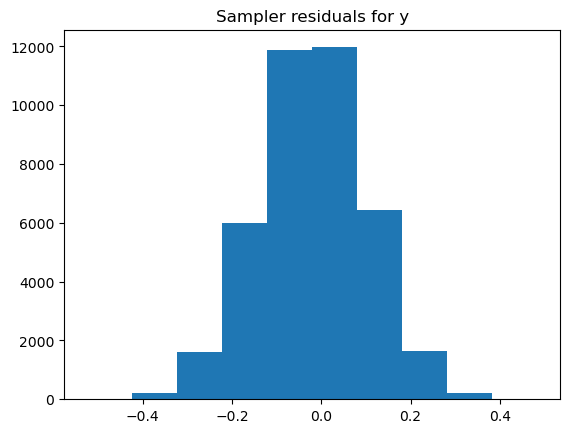

In [101]:
plt.hist((idata['posterior']['y_latent'].values.reshape([-1,10])-y_true).flatten())
plt.title("Sampler residuals for y")